# Assignment 5: (Un)supervised Machine Learning

__Task:__ Train an LDA model on your data to extract structured information that can provide insight into your data. For example, maybe you are interested in seeing how different authors cluster together or how concepts change over time in this dataset.

In [ ]:
# standard library
import sys,os
sys.path.append(os.path.join(".."))
from pprint import pprint

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])
nlp.max_length = 67000000

# visualisation
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10

# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from utils import lda_utils

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

__Load text__

In [ ]:
filename = os.path.join("..", "assignments", "data", "IMDB_reviews.txt")

In [43]:
with open(filename) as f:
    text = f.read()

__Split into individual sentences__

In [44]:
doc = nlp(text[:10000], disable = ['ner'])
sentences = [sent.string.strip() for sent in doc.sents]

__Create chunks of 10 sentences at a time__

In [45]:
chunks = []
for index in range(0, len(sentences), 10):
    chunks.append(' '.join(sentences[index:index+10]))

__Process using ```gensim```__

In [46]:
bigram = gensim.models.Phrases(chunks, min_count=3, threshold=50) 
trigram = gensim.models.Phrases(bigram[chunks], threshold=50)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [47]:
# Lemmatizing and part-of-speech tagging
data_processed = lda_utils.process_words(chunks,
                                         nlp, 
                                         bigram_mod, 
                                         trigram_mod, 
                                         allowed_postags=["NOUN"]) # we only keep nouns as part-of-speech

__Create bag of words__

In [48]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

__LDA Model__

In [49]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,    
                                       id2word=id2word,  
                                       num_topics=10,    
                                       random_state=100, 
                                       chunksize=10,     
                                       passes=10,        
                                       iterations=100,   
                                       per_word_topics=True, 
                                       minimum_probability=0.0)

__Calculate perplexity and coherence__

In [50]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.0717106681803

Coherence Score:  0.4503980590307995


__Inspect topics__

In [51]:
pprint(lda_model.print_topics())

[(0,
  '0.004*"movie" + 0.004*"br" + 0.004*"film" + 0.004*"show" + 0.004*"time" + '
  '0.004*"performance" + 0.004*"comedy" + 0.004*"air" + 0.004*"thing" + '
  '0.004*"prison"'),
 (1,
  '0.004*"movie" + 0.004*"film" + 0.004*"br" + 0.004*"time" + 0.004*"show" + '
  '0.004*"way" + 0.004*"comedy" + 0.004*"performance" + 0.004*"cast" + '
  '0.004*"scene"'),
 (2,
  '0.056*"cast" + 0.029*"performance" + 0.029*"show" + 0.029*"air" + '
  '0.029*"today" + 0.029*"success" + 0.029*"hack" + 0.029*"brilliance" + '
  '0.029*"star" + 0.029*"writing"'),
 (3,
  '0.005*"prison" + 0.005*"inmate" + 0.005*"show" + 0.005*"violence" + '
  '0.005*"injustice" + 0.005*"level" + 0.005*"episode" + 0.005*"guard" + '
  '0.005*"agreement" + 0.005*"street"'),
 (4,
  '0.004*"movie" + 0.004*"br" + 0.004*"film" + 0.004*"time" + 0.004*"show" + '
  '0.004*"thing" + 0.004*"performance" + 0.004*"way" + 0.004*"character" + '
  '0.004*"year"'),
 (5,
  '0.065*"movie" + 0.049*"film" + 0.033*"br" + 0.033*"money" + '
  '0.017*"la

__Run model multiple times to find best fit__

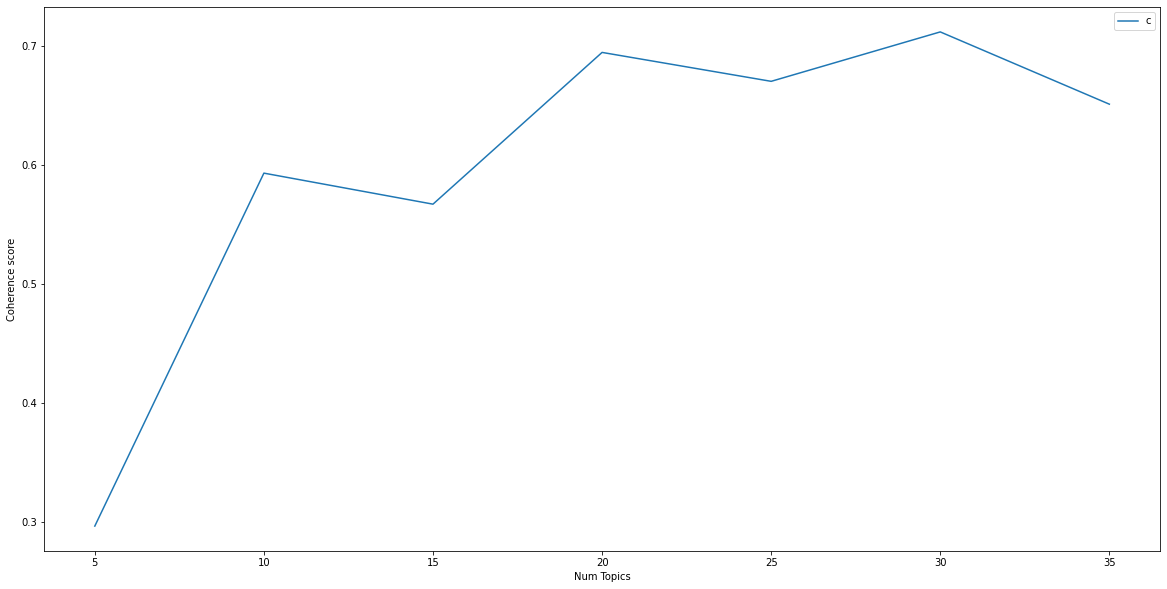

Num Topics = 5  has Coherence Value of 0.2967
Num Topics = 10  has Coherence Value of 0.5932
Num Topics = 15  has Coherence Value of 0.5671
Num Topics = 20  has Coherence Value of 0.6946
Num Topics = 25  has Coherence Value of 0.6703
Num Topics = 30  has Coherence Value of 0.7118
Num Topics = 35  has Coherence Value of 0.6511


In [52]:
model_list, coherence_values = lda_utils.compute_coherence_values(texts=data_processed,
                                                                  corpus=corpus, 
                                                                  dictionary=id2word,  
                                                                  start=5, 
                                                                  limit=40,  
                                                                  step=5)

__Most dominant topic per chunk__

In [53]:
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Chunk_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Chunk_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.9719,"br, movie, parent, drama, time, film, show, vi...","[reviewer, episode, thing, brutality, unflinch..."
1,1,6.0,0.9710,"film, br, comedy, air, way, scene, character, ...","[death, stare, dealing, agreement, appeal, sho..."
2,2,7.0,0.9550,"br, movie, parent, drama, time, film, show, vi...","[touch, side, production, br, technique, time,..."
3,3,6.0,0.9795,"film, br, comedy, air, way, scene, character, ...","[production, master, comedy, life, realism, th..."
4,4,7.0,0.9679,"br, movie, parent, drama, time, film, show, vi...","[tone, image, woman, superman, comedy, friend,..."
5,5,5.0,0.9667,"movie, film, br, money, laughter, joke, mom, b...","[shot, love, time, money, film, portrait, rela..."
6,6,8.0,0.9667,"time, movie, world, thing, year, way, people, ...","[people, world, habitat, thing, soul, stage, c..."
7,7,8.0,0.9690,"time, movie, world, thing, year, way, people, ...","[time, year, performance, tear, eye, role, kid..."
8,8,8.0,0.9550,"time, movie, world, thing, year, way, people, ...","[pace, world, water, adventure, way, outlet, v..."
9,9,2.0,0.9437,"cast, performance, show, air, today, success, ...","[today, writing, performance, guest, host, air..."


In [54]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                      axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2.0,0.9437,"cast, performance, show, air, today, success, hack, brilliance, star, writing","[today, writing, performance, guest, host, air, creator, cast, band, hack, brilliance, star, cas..."
1,5.0,0.9667,"movie, film, br, money, laughter, joke, mom, budget, gut, humour","[shot, love, time, money, film, portrait, relation, movie, money, power, success, people, situat..."
2,6.0,0.9795,"film, br, comedy, air, way, scene, character, thing, woody, guard","[production, master, comedy, life, realism, thing, fantasy, guard, dream, technique, disappear, ..."
3,7.0,0.9719,"br, movie, parent, drama, time, film, show, violence, word, piece","[reviewer, episode, thing, brutality, unflinching, scene, violence, word, trust, show, show, pun..."
4,8.0,0.9690,"time, movie, world, thing, year, way, people, kid, series, vote","[time, year, performance, tear, eye, role, kid, grandma, midget, child, fun, mother, awakening, ..."


__Visualizations with pyLDAvis__

In [55]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

TypeError: Object of type 'complex' is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
6     -0.118189+0.000000j  0.130579+0.000000j       1        1  35.214692
7     -0.113817+0.000000j -0.159848+0.000000j       2        1  23.404436
8      0.184112+0.000000j -0.020147+0.000000j       3        1  22.163611
5      0.016633+0.000000j  0.013928+0.000000j       4        1  12.529477
2      0.026869+0.000000j  0.026404+0.000000j       5        1   4.753999
9      0.000986+0.000000j  0.001716+0.000000j       6        1   0.386757
4      0.000986+0.000000j  0.001716+0.000000j       7        1   0.386757
3      0.000447+0.000000j  0.002223+0.000000j       8        1   0.386757
1      0.000986+0.000000j  0.001716+0.000000j       9        1   0.386757
0      0.000986+0.000000j  0.001716+0.000000j      10        1   0.386757, topic_info=        Term       Freq      Total Category  logprob  loglift
102    

__Visualizations with seaborn__

In [56]:
# Preprocessing
values = list(lda_model.get_document_topics(corpus))

split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

df = pd.DataFrame(map(list,zip(*split)))

<AxesSubplot:>

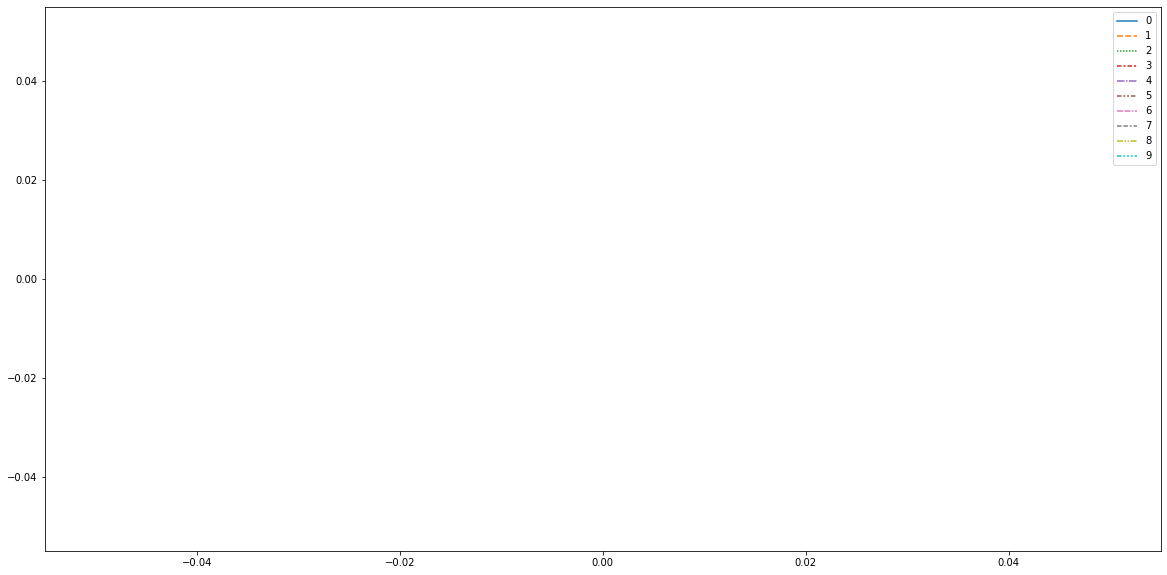

In [57]:
sns.lineplot(data=df.T.rolling(50).mean())